In [3]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 
import xgboost

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [4]:
# Load and process test data from openml

raw_data = loadarff('../data/black_friday.arff')
df_data = pd.DataFrame(raw_data[0])
y=df_data['Purchase']
X=df_data.iloc[:,:-1]

def one_hot_encode_df_max_values(df, max_unique=5):
    cat_columns = df.columns
    for col in cat_columns:
        value_counts = df[col].value_counts()
        if len(value_counts) > max_unique:
            top_values = value_counts.index[:max_unique]
            df[col] = df[col].apply(lambda x: x if x in top_values else 'Other')
        encoded = pd.get_dummies(df[col], prefix=col)
        df = df.drop(col, axis=1)
        df = pd.concat([df, encoded], axis=1)
    return df

X = one_hot_encode_df_max_values(df_data.iloc[:,:-1])
y=y/y.max()



In [10]:
import itertools
import numpy as np
import joblib

class Bandit:
    @property
    def name(self):
        return self.__class__.__name__

class XGBFR_Predictor(Bandit):
    def __init__(self, clf, epsilon: float, dimensions: int):
        if not 0 <= epsilon <= 1:
            raise ValueError("Epsilon must be between 0 and 1.")
        if dimensions <= 0:
            raise ValueError("Dimensions must be positive.")
        self.epsilon = epsilon
        self.dimensions = dimensions
        self.clf = clf
        self.rng = np.random.default_rng()

    def predict(self, featurised_vector: np.ndarray, floors: np.ndarray, exploration: bool = False):
        floor_combinations = list(itertools.combinations(floors, self.dimensions))]
        floors.sort()


        if exploration:
            assignments = self.rng.choice(floor_combinations, size=len(featurised_vector))
            propensities = np.ones(len(featurised_vector)) * self.epsilon
            return assignments, propensities

        predictions = []
        for floor_tuple in floor_combinations:
            fv_with_floors = np.concatenate(
                [featurised_vector, np.repeat([np.array(floor_tuple)], repeats=len(featurised_vector), axis=0)],
                axis=1
            )
            predictions.append(self.clf.predict(fv_with_floors))
        predictions = np.array(predictions)
        best_indices = np.argmin(predictions, axis=0)
        assignments = np.array(floor_combinations)[best_indices]
        propensities = np.ones(len(featurised_vector)) * (1 - self.epsilon)

        mask = rng.uniform(size=len(featurised_vector)) < self.epsilon
        if mask.any():
            assignments[mask] = self.rng.choice(floor_combinations, size=mask.sum())
            propensities[mask] = self.epsilon

        return assignments, propensities

    def save(self, path: str):
        joblib.dump(self, path)

class XGBFR_Trainer(Bandit):
    def __init__(self, clf, dimensions: int, epsilon: float):
        if not 0 <= epsilon <= 1:
            raise ValueError("Epsilon must be between 0 and 1.")
        if dimensions <= 0:
            raise ValueError("Dimensions must be positive.")
        self.clf = clf
        self.dimensions = dimensions
        self.epsilon = epsilon

    def update(self, featurised_vector: np.ndarray, assignments, propensities, rewards):
        X = np.hstack([featurised_vector, assignments])
        sample_weights = 1 / propensities
        self.clf.fit(X, rewards, sample_weight=sample_weights)

    def save(self, path: str):
        predictor = self.create_predictor()
        joblib.dump(predictor, path)

    def create_predictor(self):
        return XGBFR_Predictor(self.clf, self.epsilon, self.dimensions)


In [6]:
batch_size=10000
num_iterations=10
floors = list(range(9))

xgb_model = xgboost.XGBRegressor(
            objective='reg:squarederror',  
            n_estimators=100,              
            learning_rate=0.1,             
            max_depth=3,                  
            random_state=42)

In [7]:
floors=np.linspace(0,1,8)

In [8]:

propensities=[] # likelihood of assignment given a reward under the policy
rewards=[] # the reward
assignments=[] # the chosen ad floors
featurised_vector=[] # the context
b_trainer=XGBFR_Trainer(clf=xgb_model,dimensions=2,epsilon=0.1)
bandit_performance_array=[0] # The recorded performance of the bandit. 
exploration=True
for i in range(0,num_iterations):
    featurised_vector_batch= X[i*batch_size:(i+1)*batch_size].values
    b_predictor=b_trainer.create_predictor()
    batch_assignments,batch_propensities=b_predictor.predict(featurised_vector_batch,floors,exploration)
    exploration = False 
    assignments.extend(batch_assignments)
    featurised_vector.extend(featurised_vector_batch)
    propensities.extend(batch_propensities)
    rewards=np.abs(y[:len(assignments)]-np.array(assignments)[:,0]) # The reward function. This will be the ad impression reward.
    bandit_performance_array.append(rewards.sum())
    b_trainer.update(np.array(featurised_vector),np.array(assignments),np.array(propensities),rewards)
    


In [22]:
assignments


[array([0.57142857, 1.        ]),
 array([0.14285714, 0.42857143]),
 array([0.71428571, 1.        ]),
 array([0.28571429, 0.85714286]),
 array([0.14285714, 1.        ]),
 array([0.28571429, 0.71428571]),
 array([0.57142857, 0.85714286]),
 array([0.28571429, 0.42857143]),
 array([0.28571429, 0.71428571]),
 array([0.        , 0.57142857]),
 array([0.57142857, 0.71428571]),
 array([0.42857143, 1.        ]),
 array([0.85714286, 1.        ]),
 array([0., 1.]),
 array([0.14285714, 0.42857143]),
 array([0.        , 0.42857143]),
 array([0.14285714, 1.        ]),
 array([0.14285714, 0.42857143]),
 array([0.        , 0.28571429]),
 array([0.28571429, 1.        ]),
 array([0.28571429, 0.85714286]),
 array([0.71428571, 0.85714286]),
 array([0.28571429, 0.57142857]),
 array([0.        , 0.71428571]),
 array([0.        , 0.28571429]),
 array([0.42857143, 0.85714286]),
 array([0.        , 0.42857143]),
 array([0.28571429, 1.        ]),
 array([0.28571429, 0.71428571]),
 array([0.28571429, 1.        

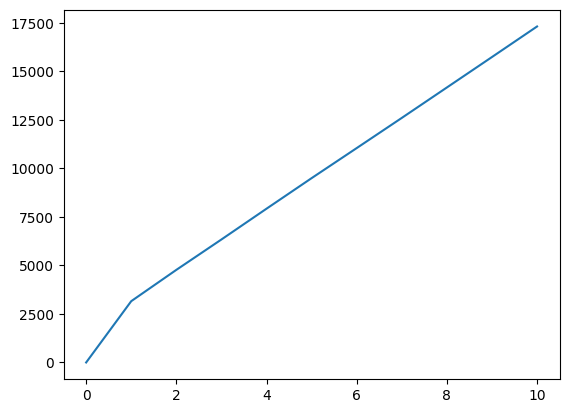

In [9]:
bandit_performance_array=np.array(bandit_performance_array)
plt.plot(bandit_performance_array)